In [1]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor
import optimizor

from optimizor import eta_2_Gamma
from optimizor import Gamma_2_eta
from optimizor import logdotexp

np.random.seed(0)
random.seed(0)

# Initialize Parameters

In [7]:
# parameters for data
pars = Parameters.Parameters()
pars.features = [{'Y':{'corr':False,'f':'normal'}}, # coarse-scale
                 {}]
pars.K = [3,1]
T = 10000
experiment = 1


if experiment == 1:
    
    Gamma = np.array([[0.9,0.05,0.05],
                      [0.05,0.9,0.05],
                      [0.05,0.05,0.9]])
    delta = np.ones(pars.K[0])/pars.K[0]
    mus = np.array(range(pars.K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))
    
elif experiment == 2:
    
    Gamma = np.array([[0.99,0.005,0.005],
                      [0.005,0.99,0.005],
                      [0.005,0.005,0.99]])
    delta = np.ones(pars.K[0])/pars.K[0]
    mus = np.array(range(pars.K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))

    
# optimization parameters 
methods = ["GD","SAGA","EM","BFGS","Nelder-Mead"]
# methods = ["EM","SGD","SAG","SVRG","SAGA","GD","BFGS","Nelder-Mead"]

# pick optimization settings
step_sizes = {"EM"  : [None,None],
              "Nelder-Mead": [None,None],
              "BFGS": [None,None],
              "GD"  : [0.01,0.01],
              "SGD" : [0.01,0.01],
              "SAG" : [0.01,0.01],
              "SVRG": [0.01,0.01],
              "SAGA": [0.01,0.01]}

num_epochs = 50
tol = 1e-10
grad_tol = 1e-8

# Simulate Data

In [4]:
X = np.zeros(T,dtype=int)
data = []

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(pars.K[0],p=delta)
    else:
        X[t] = np.random.choice(pars.K[0],p=Gamma[X[t-1]])

    data.append({'Y':mus[X[t]] + sigs[X[t]]*np.random.normal(),
                 'subdive_features':[]})

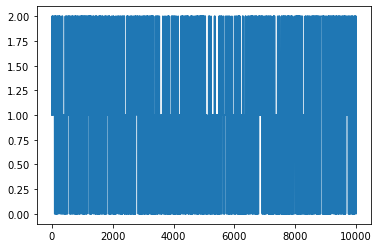

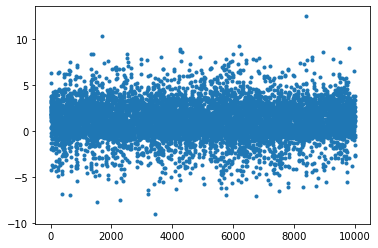

In [5]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.show()

# Train the HMM

In [8]:
importlib.reload(optimizor)

# intialize HHMM
hhmm = HHMM.HHMM(pars,data)

hhmm.theta = [{'Y': {'mu': np.array([-1.0,  1.1,  2.1]),
                     'log_sig': np.array([0.0, 0.0, 0.0]),
                     'corr': np.zeros(pars.K[0])}},
               [{}, {}, {}]]

hhmm.Gamma = [Gamma,
             [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

hhmm.eta = Gamma_2_eta(hhmm.Gamma)

# initialize optims
#optims = {}
#times = {}

# get optimal value via EM:
#optims["control"] = optimizor.optimizor(hhmm)
#optims["control"].step_size = [None,None]
#optims["control"].param_bounds["Y"]["mu"] = [-100,100]
#optims["control"].param_bounds["Y"]["log_sig"] = [-5,5]

#optims["control"].train_HHMM(num_epochs=num_epochs,
#                                      method="EM",
#                                      tol=1e-15)
#optim_ll = optims["control"].log_like_trace[-1]
    
for method in methods:
    
    for partial_E in [0,0.5,1]:
        
        if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead"]:
            continue
        
        print(method,partial_E)
        print("")

        optims[(method,partial_E)] = optimizor.optimizor(hhmm)
        optims[(method,partial_E)].step_size = step_sizes[method]
        optims[(method,partial_E)].param_bounds["Y"]["mu"] = [-100,100]
        optims[(method,partial_E)].param_bounds["Y"]["log_sig"] = [-5,5]
        
        if partial_E == 0:
            optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                  method=method,
                                                  max_iters=T,
                                                  partial_E=False,
                                                  alpha_theta=step_sizes[method][0],
                                                  alpha_eta=step_sizes[method][1],
                                                  tol=tol,
                                                  grad_tol=grad_tol,
                                                  record_like = True)
        elif partial_E == 0.5:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like = True)
        elif partial_E == 1:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=10*T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like = True)

GD 0

starting epoch 0.0

starting E-step...
...done
-22575.497310531173
starting M-step...
...done

starting epoch 0.5

starting E-step...
...done
-22529.472391067935
starting M-step...
...done

starting epoch 1.0

starting E-step...
...done
-22484.694403217032
starting M-step...
...done

starting epoch 1.5

starting E-step...
...done
-22441.12108898195
starting M-step...
...done

starting epoch 2.0

starting E-step...
...done
-22398.71135159764
starting M-step...
...done

starting epoch 2.5

starting E-step...
...done
-22357.425327691195
starting M-step...
...done

starting epoch 3.0

starting E-step...
...done
-22317.224431796716
starting M-step...
...done

starting epoch 3.5

starting E-step...
...done
-22278.07137911739
starting M-step...
...done

starting epoch 4.0

starting E-step...
...done
-22239.930191312793
starting M-step...
...done

starting epoch 4.5

starting E-step...
...done
-22202.766189175047
starting M-step...
...done

starting epoch 5.0

starting E-step...
...done


...done
-20816.666663977194
starting M-step...
...done

starting epoch 43.5

starting E-step...
...done
-20808.104981991044
starting M-step...
...done

starting epoch 44.0

starting E-step...
...done
-20799.660167511152
starting M-step...
...done

starting epoch 44.5

starting E-step...
...done
-20791.329876763026
starting M-step...
...done

starting epoch 45.0

starting E-step...
...done
-20783.111826638265
starting M-step...
...done

starting epoch 45.5

starting E-step...
...done
-20775.003792813608
starting M-step...
...done

starting epoch 46.0

starting E-step...
...done
-20767.003607939194
starting M-step...
...done

starting epoch 46.5

starting E-step...
...done
-20759.109159892178
starting M-step...
...done

starting epoch 47.0

starting E-step...
...done
-20751.318390093955
starting M-step...
...done

starting epoch 47.5

starting E-step...
...done
-20743.629291887253
starting M-step...
...done

starting epoch 48.0

starting E-step...
...done
-20736.039908971823
starting M-s

...done
-16839.88089575558
starting M-step...
1.9037554238281692e-06
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 39.0

starting E-step...
...done
-16839.88089247114
starting M-step...
1.4318006573701711e-06
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 40.0

starting E-step...
...done
-16839.88089058521
starting M-step...
1.0530780486747017e-06
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 41.0

starting E-step...
...done
-16839.880889517994
relative change of log likelihood is less than 1.0E-10. returning...
SAGA 0.5

starting epoch 0.0

starting E-step...
...done
-22575.497310531173
starting M-step...
0.25137399393692783
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 1.5

starting E-step...
...done
-17084.55054917584
starting M-step...
0.06317887672042166
M-step failed to converge: maximum number of iterations reached

KeyboardInterrupt: 

# Plot Results

In [ ]:
def plot_ll(optims,x_time=False):
    
    ll_star = optims["control"].log_like_trace[-1]
    legend = []
    
    for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
        
        if method == "BFGS":
            continue
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta^*, \eta^*) - \log p(\mathbf{y} ; \theta, \eta)\right]$")
    plt.legend(legend)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_exp_%d.png" % experiment,dpi=200)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_exp_%d.png" % experiment,dpi=200)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,experiment=1,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    if method.startswith("SAGA"):
        x = (np.arange(iters) / optim.T)
    else:
        x = np.arange(iters)
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=200)
    plt.show()

    # plot means
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['mu'][k] for i in range(iters)])
        legend.append(r"$\mu^{(%d)}$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline, c = 'k', linestyle = "--")
        
    plt.title("$\mu$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/mu-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=200)
    plt.show()
    
    # plot log(sigma)
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['log_sig'][k] for i in range(len(optim.theta_trace))])
        legend.append(r"$\log\left(\sigma^{(%d)}\right)$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline-1, c = 'k', linestyle = "--")
        
    plt.title(r"$\log\left(\sigma\right)$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/log-sig-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=200)
    plt.show()
    
    # plot eta
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=200)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

In [ ]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],optim_ll,method,PE,M)

In [ ]:
optims[("BFGS",0)].time_trace

In [ ]:
optims[("BFGS",0)].log_like_trace

In [ ]:
optims[("BFGS",0)].log_like_trace = [-x for x in optims[("BFGS",0)].log_like_trace]